# Milestone 1

# Introduction

```txt
Nama : Maulana Azmi Izzuddin
Batch: FTDS-013
```

# link heroku app = https://maulana-azmi-i-ftds-013-p0m1.herokuapp.com/

# Problems

```txt
Kamu adalah seorang Data Analyst yang akan mengerjakan projek besar untuk menyelesaikan suatu permasalahan client dan client kamu butuh sekali hasil analisa datamu menggunakan statistik dan dashboard visualisasi data untuk membantu mereka menyelesaikan masalah. Pilihlah satu dari empat masalah berikut yang dapat kamu bantu selesaikan:

Tim sukses seorang politisi di California ingin mengadakan kampanye menggunakan Google Ads. Namun, mereka tidak tahu apakah kampanye ini akan berhasil atau tidak dan butuh budget seberapa besar per bulannya. Bantu mereka untuk mengetahui apakah kampanye di Google Ads ini efektif atau tidak. Gunakan dataset google_political_ads di Google Cloud Platform BigQuery.
```


# Penjabaran Masalah

* Bagaimana perilaku warga United States dalam mengeluarkan US dollar untuk sebuah iklan terhadap impression yang di dapat? (Visual)
* Bagiamana persebaran data pada impression yang di dapat dari sebuah ads di United States? (Deskriptif)
* Bagiamana persebaran data pada US dollar yang dikeluarkan untuk sebuah ads di United States? (Deskriptif)
* Bagaimana persebaran total ads yang ditujukan pada setiap states di United States?(Visual)
* Bagaimana persebaran total dana yang dikeluarkan pada suatu iklan yang ditujukan pada setiap states di United States? (Visual)
* Gender apa saja yang menjadi target dalam political ads? Bagaimana proporsinya? (Visual)
* Tipe ads apa yang paling di rekomendasikan? (Visual)
* Apakah impressions yang didapatkan pada setiap tipe ads sama? (Inferensial)



# Metric

* advertiser_id
* total_spend
* total_creatives
* num_of_days
* max_impressions
* ads_type
* total ads per state
* total spend per state
* latitude,longitude : external bukan dari bigquery
* gender_targeting
* total spend per ads type
* impression per ads type


# List of Query

Query pertama dilakukan untuk mendapatkan data yang akan digunakan untuk analisa terkait seberapa banyak total spending per ads nya dan juga seberapa banyak impressions yang di dapat dan berapa lama ads itu dijalankan.

Query ini dilakukan dengan menggunakan agg function, subquery, dan dilakukan juga inner join dengan key nya advertiser_id.

Dilakukan GroupBy untuk melihat aktivitas dari setiap advertiser_id yang dimana setiap orang tidak hanya mengeluarkan 1 ads saja melainkan bisa lebih.

```txt
SELECT  spend.advertiser_id,spend.advertiser_name, SUM(spend.spend_usd) AS total_spend_usd,stats.total_creatives,stats_imp.maximum_impressions,stats_imp.total_day
FROM `bigquery-public-data.google_political_ads.advertiser_geo_spend` spend 
INNER JOIN `bigquery-public-data.google_political_ads.advertiser_stats` stats
ON spend.advertiser_id = stats.advertiser_id
INNER JOIN
(
  SELECT SUM(CAST(REGEXP_SUBSTR (impressions, "-(.*)") AS INT)) AS maximum_impressions,advertiser_id,SUM(num_of_days) AS total_day
  FROM `bigquery-public-data.google_political_ads.creative_stats`
  GROUP BY advertiser_id) AS stats_imp
ON spend.advertiser_id = stats_imp.advertiser_id
WHERE spend.country ="US"
GROUP BY spend.advertiser_id,spend.advertiser_name, stats.total_creatives,stats_imp.maximum_impressions,stats_imp.total_day
ORDER BY spend.advertiser_id;
```

Query kedua dilakukan untuk mendapatkan data dari spending dan total ads yang ada pada setiap state di United States.

```txt
SELECT geo.country, geo.state, geo.total_district,total_ads ,total_spend
FROM 
(SELECT country, REGEXP_SUBSTR (country_subdivision_primary, "-(.*)") AS state, COUNT(spend_usd) AS total_district,SUM(spend_usd) AS total_spend
  FROM `bigquery-public-data.google_political_ads.geo_spend` 
  GROUP BY state,country
) AS geo
INNER JOIN 
(SELECT  country_subdivision_primary,COUNT(country) AS total_ads
FROM `bigquery-public-data.google_political_ads.advertiser_geo_spend`
GROUP BY country_subdivision_primary
) AS ads_state
ON geo.state = ads_state.country_subdivision_primary 
WHERE geo.country = "US"
AND geo.state  IS NOT NULL
GROUP BY geo.state,geo.country,geo.total_district,total_ads ,total_spend;
```

Query ketiga dilakukan untuk mendapatkan data impression yang didapatkan dan spending yang dikeluarkan untuk setiap tipe ads.

```txt
SELECT imp.regions, imp.ad_type, imp.impressions , imp.spend_usd
FROM 
(
  SELECT regions,ad_type, REGEXP_SUBSTR (impressions, "-(.*)") AS impressions, spend_range_max_usd AS spend_usd
  FROM`bigquery-public-data.google_political_ads.creative_stats` ) AS imp
WHERE imp.regions = "US"
AND imp.impressions IS NOT NULL;
```

Query keempat untuk mendapatkan persebaran targeting gender terhadap todal ads yang dikeluarkan.

```txt
SELECT advertiser_id, gender_targeting
FROM `bigquery-public-data.google_political_ads.creative_stats` 
WHERE gender_targeting IS NOT NULL
AND regions = "US";
```

# Import Library yang diperlukan

In [118]:
import pandas as pd #manipulasi data
import numpy as np #komputasi array
import matplotlib.pyplot as plt #plotting
import scipy.stats as stats #uji anova dan statistik lainnya
import seaborn as sns #plotting
import plotly.graph_objects as go #plotting

# Loading dan Manipulation data

## Query 1 Data Utama

Melakukan loading data query 1 dan menunjukan head dan tail data.

In [119]:
ads_data = pd.read_csv("deployment/ads_data.csv")
ads_data.head()

,advertiser_id,advertiser_name,total_spend_usd,total_creatives,maximum_impressions,total_day
0,AR00000475401340059649,VINCE LEACH FOR SENATE,10500,5,865000.0,276
1,AR00008638175664668673,TINA SMITH FOR MINNESOTA,251500,111,8346000.0,2294
2,AR00013006535361822721,NICK LALOTA FOR CONGRESS,3300,3,31000.0,138
3,AR00013986200222171137,VESCOGNI FOR STATES ATTORNEY,400,3,3000.0,41
4,AR00017645374919409665,DEMOCRATIC PARTY OF OREGON,6200,8,84000.0,96


In [120]:
ads_data.tail()

,advertiser_id,advertiser_name,total_spend_usd,total_creatives,maximum_impressions,total_day
6414,AR18430858742028304385,Rod Honeycutt For Congress,5100,2,176000.0,7
6415,AR18433708676167499777,COMMITTEE TO ELECT MEG LOUGHRAN CAPPEL,1400,44,44000.0,351
6416,AR18434980811120836609,PEOPLE FOR MARK LUFT,5500,2,200000.0,12
6417,AR18437367850864738305,AMERICANS FOR PROSPERITY,1306600,654,119027000.0,13140
6418,AR18441871450492108801,SAM GRAVES VICTORY FUND,2100,7,54000.0,316


In [121]:
ads_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6419 entries, 0 to 6418
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   advertiser_id        6419 non-null   object 
 1   advertiser_name      6419 non-null   object 
 2   total_spend_usd      6419 non-null   int64  
 3   total_creatives      6419 non-null   int64  
 4   maximum_impressions  6418 non-null   float64
 5   total_day            6419 non-null   int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 301.0+ KB


Terlihat ternyata terdapat missing value pada kolom maximum_impressions.

In [122]:
ads_data.dropna(subset=['maximum_impressions'],inplace=True)

Melakukan drop missing value agar data bersih dari missing value.

In [123]:
ads_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6418 entries, 0 to 6418
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   advertiser_id        6418 non-null   object 
 1   advertiser_name      6418 non-null   object 
 2   total_spend_usd      6418 non-null   int64  
 3   total_creatives      6418 non-null   int64  
 4   maximum_impressions  6418 non-null   float64
 5   total_day            6418 non-null   int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 351.0+ KB


Terlihat pada data sudah tidak ada missing value.

Membuat column yang berisikan impressions/ ads sehingga disini ingin mengetahui value seberapa banyak impression yang didapatkan dalam satu iklan. namun sebelum itu kita perlu mengetahui impression/day nya (seberapa banyak impression yang didapat dalam 1 hari)

In [124]:
ads_data['impressions_per_day'] = ads_data['maximum_impressions']/ads_data['total_day']
ads_data

,advertiser_id,advertiser_name,total_spend_usd,total_creatives,maximum_impressions,total_day,impressions_per_day
0,AR00000475401340059649,VINCE LEACH FOR SENATE,10500,5,865000.0,276,3134.057971
1,AR00008638175664668673,TINA SMITH FOR MINNESOTA,251500,111,8346000.0,2294,3638.186574
2,AR00013006535361822721,NICK LALOTA FOR CONGRESS,3300,3,31000.0,138,224.637681
3,AR00013986200222171137,VESCOGNI FOR STATES ATTORNEY,400,3,3000.0,41,73.170732
4,AR00017645374919409665,DEMOCRATIC PARTY OF OREGON,6200,8,84000.0,96,875.000000
...,...,...,...,...,...,...,...
6414,AR18430858742028304385,Rod Honeycutt For Congress,5100,2,176000.0,7,25142.857143
6415,AR18433708676167499777,COMMITTEE TO ELECT MEG LOUGHRAN CAPPEL,1400,44,44000.0,351,125.356125
6416,AR18434980811120836609,PEOPLE FOR MARK LUFT,5500,2,200000.0,12,16666.666667
6417,AR18437367850864738305,AMERICANS FOR PROSPERITY,1306600,654,119027000.0,13140,9058.371385


In [125]:
ads_data['impressions_per_ads'] = ads_data['impressions_per_day']/ads_data['total_creatives']
ads_data

,advertiser_id,advertiser_name,total_spend_usd,total_creatives,maximum_impressions,total_day,impressions_per_day,impressions_per_ads
0,AR00000475401340059649,VINCE LEACH FOR SENATE,10500,5,865000.0,276,3134.057971,626.811594
1,AR00008638175664668673,TINA SMITH FOR MINNESOTA,251500,111,8346000.0,2294,3638.186574,32.776456
2,AR00013006535361822721,NICK LALOTA FOR CONGRESS,3300,3,31000.0,138,224.637681,74.879227
3,AR00013986200222171137,VESCOGNI FOR STATES ATTORNEY,400,3,3000.0,41,73.170732,24.390244
4,AR00017645374919409665,DEMOCRATIC PARTY OF OREGON,6200,8,84000.0,96,875.000000,109.375000
...,...,...,...,...,...,...,...,...
6414,AR18430858742028304385,Rod Honeycutt For Congress,5100,2,176000.0,7,25142.857143,12571.428571
6415,AR18433708676167499777,COMMITTEE TO ELECT MEG LOUGHRAN CAPPEL,1400,44,44000.0,351,125.356125,2.849003
6416,AR18434980811120836609,PEOPLE FOR MARK LUFT,5500,2,200000.0,12,16666.666667,8333.333333
6417,AR18437367850864738305,AMERICANS FOR PROSPERITY,1306600,654,119027000.0,13140,9058.371385,13.850721


Lalu menambah column baru yang berisikan tentang seberapa banyak impression yang didapatkan dalam 1 hari dengan pengeluaran 1 dolar dengan membagikan column impression_per_ads (yang dimana ini sudah dibagi dengan per hari dan per 1 ads) dengan total_spend (total spend ini sudah total dari jumlah ads dan jumlah hari nya).

In [126]:
ads_data['impressions_per_spend'] = ads_data['impressions_per_ads']/ads_data['total_spend_usd']
ads_data

,advertiser_id,advertiser_name,total_spend_usd,total_creatives,maximum_impressions,total_day,impressions_per_day,impressions_per_ads,impressions_per_spend
0,AR00000475401340059649,VINCE LEACH FOR SENATE,10500,5,865000.0,276,3134.057971,626.811594,0.059696
1,AR00008638175664668673,TINA SMITH FOR MINNESOTA,251500,111,8346000.0,2294,3638.186574,32.776456,0.000130
2,AR00013006535361822721,NICK LALOTA FOR CONGRESS,3300,3,31000.0,138,224.637681,74.879227,0.022691
3,AR00013986200222171137,VESCOGNI FOR STATES ATTORNEY,400,3,3000.0,41,73.170732,24.390244,0.060976
4,AR00017645374919409665,DEMOCRATIC PARTY OF OREGON,6200,8,84000.0,96,875.000000,109.375000,0.017641
...,...,...,...,...,...,...,...,...,...
6414,AR18430858742028304385,Rod Honeycutt For Congress,5100,2,176000.0,7,25142.857143,12571.428571,2.464986
6415,AR18433708676167499777,COMMITTEE TO ELECT MEG LOUGHRAN CAPPEL,1400,44,44000.0,351,125.356125,2.849003,0.002035
6416,AR18434980811120836609,PEOPLE FOR MARK LUFT,5500,2,200000.0,12,16666.666667,8333.333333,1.515152
6417,AR18437367850864738305,AMERICANS FOR PROSPERITY,1306600,654,119027000.0,13140,9058.371385,13.850721,0.000011


Membuat colum baru berisikan info terkait sebara banyak usd yang dikeluarkan dalam membuat 1 iklan per 1 hari dengan formula total_spend_usd / (total_creatives)*(total_day)

In [127]:
ads_data['usd_per_ads_day'] = ads_data['total_spend_usd']/(ads_data['total_creatives']*ads_data['total_day'])
ads_data

,advertiser_id,advertiser_name,total_spend_usd,total_creatives,maximum_impressions,total_day,impressions_per_day,impressions_per_ads,impressions_per_spend,usd_per_ads_day
0,AR00000475401340059649,VINCE LEACH FOR SENATE,10500,5,865000.0,276,3134.057971,626.811594,0.059696,7.608696
1,AR00008638175664668673,TINA SMITH FOR MINNESOTA,251500,111,8346000.0,2294,3638.186574,32.776456,0.000130,0.987692
2,AR00013006535361822721,NICK LALOTA FOR CONGRESS,3300,3,31000.0,138,224.637681,74.879227,0.022691,7.971014
3,AR00013986200222171137,VESCOGNI FOR STATES ATTORNEY,400,3,3000.0,41,73.170732,24.390244,0.060976,3.252033
4,AR00017645374919409665,DEMOCRATIC PARTY OF OREGON,6200,8,84000.0,96,875.000000,109.375000,0.017641,8.072917
...,...,...,...,...,...,...,...,...,...,...
6414,AR18430858742028304385,Rod Honeycutt For Congress,5100,2,176000.0,7,25142.857143,12571.428571,2.464986,364.285714
6415,AR18433708676167499777,COMMITTEE TO ELECT MEG LOUGHRAN CAPPEL,1400,44,44000.0,351,125.356125,2.849003,0.002035,0.090650
6416,AR18434980811120836609,PEOPLE FOR MARK LUFT,5500,2,200000.0,12,16666.666667,8333.333333,1.515152,229.166667
6417,AR18437367850864738305,AMERICANS FOR PROSPERITY,1306600,654,119027000.0,13140,9058.371385,13.850721,0.000011,0.152044


In [128]:
ads_data[ads_data['usd_per_ads_day']==0]

,advertiser_id,advertiser_name,total_spend_usd,total_creatives,maximum_impressions,total_day,impressions_per_day,impressions_per_ads,impressions_per_spend,usd_per_ads_day
167,AR00419310166685515777,VOTERS FOR TRUTH PC,0,1,1000.0,1,1000.000000,1000.000000,inf,0.0
174,AR00446859530031071233,Hoopes 2022,0,7,7000.0,34,205.882353,29.411765,inf,0.0
319,AR00860662930167824385,INDABA APPLICATION NETWORK,0,1,1000.0,4,250.000000,250.000000,inf,0.0
518,AR01392087686197542913,JENNIFER BARBOSA FOR CONGRESS,0,1,1000.0,1,1000.000000,1000.000000,inf,0.0
556,AR01491166877999693825,UNDERLY FOR WI,0,1,1000.0,5,200.000000,200.000000,inf,0.0
587,AR01586518175627870209,ISLAND RICHARDS FOR COMMISSIONER,0,1,1000.0,2,500.000000,500.000000,inf,0.0
896,AR02531863704660606977,FOCUS ON WHITPAIN,0,1,1000.0,1,1000.000000,1000.000000,inf,0.0
1406,AR03968511985791795201,Empower Northeast Denver,0,1,1000.0,1,1000.000000,1000.000000,inf,0.0
1932,AR05497118746545750017,CARR FOR DELEGATE,0,1,1000.0,1,1000.000000,1000.000000,inf,0.0
2477,AR06993778922076766209,CAMPAIGN FUND OF SHARPE ELECTION COMMITTEE,0,1,1000.0,2,500.000000,500.000000,inf,0.0


Karena terdapat value spend dollars 0 tetapi mengeluarkan iklan atau ads dengan adanya impressions juga maka disini Saya asumsikan terdapat miss entry pada big query pada advertiser tersebut. sehingga disini Saya akan drop yang memiliki total spend ==0

In [129]:
ads_data.drop(ads_data[ads_data['usd_per_ads_day']==0].index,inplace=True)

Sehingga dalam analisa kasus ini menggunakan tiga metric, yaitu:
* impressions_per_ads ini adalah metric untuk mengetahui seberapa banyak impressions yang didapat dalam 1 iklan dalam 1 hari.
* usd_per_ads_day ini adalah metric untuk mengetahui seberapa banyajk us dollar yang diperlukan dalam 1 iklan dalam 1 hari.

to_csv untuk save dataframe ke dalam format csv.

In [130]:
#ads_data.to_csv("data_ads.csv")

## Map

Loading data query kedua.

In [131]:
based_geo = pd.read_csv('deployment/ads_based_geo.csv')
based_geo.head(10)

,country,state,total_district,total_ads,total_spend
0,US,AK,1,3947,2255900
1,US,AL,7,4786,6926000
2,US,AR,4,4638,3485800
3,US,AZ,9,4993,41728600
4,US,CA,53,5332,93639700
5,US,CO,7,4989,17811700
6,US,CT,5,4333,4654800
7,US,DC,1,4415,4646400
8,US,DE,1,4167,1487500
9,US,FL,27,5235,76862200


Menampilkan data pertama dan terakhir dengan .head .tail

In [132]:
based_geo.tail()

,country,state,total_district,total_ads,total_spend
46,US,VT,1,4339,1022600
47,US,WA,10,4735,12320700
48,US,WI,8,4889,24636600
49,US,WV,3,4625,3290200
50,US,WY,1,4396,737700


In [133]:
based_geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   country         51 non-null     object
 1   state           51 non-null     object
 2   total_district  51 non-null     int64 
 3   total_ads       51 non-null     int64 
 4   total_spend     51 non-null     int64 
dtypes: int64(3), object(2)
memory usage: 2.1+ KB


Dapat dilihat tidak ada missing value.

Saya juga menambahkan suatu data bernama states.csv yang berisikan data latitude longitude dari setiap state di US yang didapat dari google.
https://developers.google.com/public-data/docs/canonical/states_csv

In [134]:
state_data = pd.read_csv("deployment/states.csv")
state_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   state      52 non-null     object 
 1   latitude   52 non-null     float64
 2   longitude  52 non-null     float64
 3   name       52 non-null     object 
dtypes: float64(2), object(2)
memory usage: 1.8+ KB


Lalu menggabungkan kedua data frame dengan cara mencocokkan state nya a.k.a key = state dengan menggunakan merge left join.

In [135]:
based_geo_long_lat = based_geo.merge(state_data,left_on='state',right_on='state')

Terlihat dataframe sudah tergabung dan sudah berisikan lengkap statistik total_spend dan total adsnya per state dengan ditambah geo locationnya (latitude,longitude)

In [136]:
based_geo_long_lat

,country,state,total_district,total_ads,total_spend,latitude,longitude,name
0,US,AK,1,3947,2255900,63.588753,-154.493062,Alaska
1,US,AL,7,4786,6926000,32.318231,-86.902298,Alabama
2,US,AR,4,4638,3485800,35.201050,-91.831833,Arkansas
3,US,AZ,9,4993,41728600,34.048928,-111.093731,Arizona
4,US,CA,53,5332,93639700,36.778261,-119.417932,California
5,US,CO,7,4989,17811700,39.550051,-105.782067,Colorado
6,US,CT,5,4333,4654800,41.603221,-73.087749,Connecticut
7,US,DC,1,4415,4646400,38.905985,-77.033418,District of Columbia
8,US,DE,1,4167,1487500,38.910832,-75.527670,Delaware
9,US,FL,27,5235,76862200,27.664827,-81.515754,Florida


Pada data ini Saya ingin memvisualisasikan dalam bentuk map dengan scatterplot bubble untuk melihat distribusi total ads dan total spend yang dilakukan per state.

to_csv untuk save dataframe ke dalam format csv.

In [137]:
#based_geo_long_lat.to_csv('geo_distribution_data.csv')

## Gender

Load data gender Query 4 yang akan digunakan dalam analisa persebaran target gender.

In [138]:
based_gender = pd.read_csv('deployment/ads_based_gender.csv')
based_gender.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212637 entries, 0 to 212636
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   advertiser_id     212637 non-null  object
 1   gender_targeting  212637 non-null  object
dtypes: object(2)
memory usage: 3.2+ MB


menampilkan 10 data pertama.

In [139]:
based_gender.head(10)

,advertiser_id,gender_targeting
0,AR03944784249986482177,"Male, Female, Unknown gender"
1,AR00887684527932047361,Unknown gender
2,AR01342548090296467457,Female
3,AR04670024593568694273,"Male, Female, Unknown gender"
4,AR04670024593568694273,Female
5,AR00035659773428891649,"Male, Female, Unknown gender"
6,AR17033089192055275521,"Male, Female, Unknown gender"
7,AR17033089192055275521,"Male, Female, Unknown gender"
8,AR07232495815728562177,"Male, Female, Unknown gender"
9,AR07232495815728562177,"Male, Female, Unknown gender"


In [140]:
based_gender['gender_targeting'].unique()

array(['Male, Female, Unknown gender', 'Unknown gender', 'Female',
       'Male, Unknown gender', 'Female, Unknown gender', 'Male',
       'Male, Female'], dtype=object)

In [141]:
gender = [] #membuat list kosong untuk sebagai storage sementara cleaning column gender_targeting
for i in range(0,len(based_gender)):
    if based_gender.iloc[i,1] == 'Male, Female, Unknown gender':
        gender.append('All Gender')
    elif based_gender.iloc[i,1] == 'Unknown gender':
        gender.append('All Gender')
    elif based_gender.iloc[i,1] == 'Male, Female':
        gender.append('All Gender')
    elif based_gender.iloc[i,1] == 'Male':
        gender.append('Male')
    elif based_gender.iloc[i,1] == 'Male, Unknown gender':
        gender.append('Male')
    elif based_gender.iloc[i,1] == 'Female':
        gender.append('Female')
    elif based_gender.iloc[i,1] == 'Female, Unknown gender':
        gender.append('Female')
len(gender)

212637

Membuat kolom gender baruyang dimana kolom sebelumnya dinpretasikan ke kata-baru yang lebih 'categorical'.

In [142]:
based_gender['gender'] = gender

In [143]:
based_gender

,advertiser_id,gender_targeting,gender
0,AR03944784249986482177,"Male, Female, Unknown gender",All Gender
1,AR00887684527932047361,Unknown gender,All Gender
2,AR01342548090296467457,Female,Female
3,AR04670024593568694273,"Male, Female, Unknown gender",All Gender
4,AR04670024593568694273,Female,Female
...,...,...,...
212632,AR13516143195817246721,Female,Female
212633,AR13405439692208340993,"Male, Female, Unknown gender",All Gender
212634,AR02874137276340764673,"Male, Female, Unknown gender",All Gender
212635,AR02719805151341707265,"Male, Female, Unknown gender",All Gender


Karena sudah ada column gender yang baru yang sudah dilakukan cleaning maka column gender_targeting sudah tidak diperlukan lagi, maka akan di remove.

In [144]:
based_gender.drop(columns='gender_targeting',inplace=True)

In [145]:
based_gender

,advertiser_id,gender
0,AR03944784249986482177,All Gender
1,AR00887684527932047361,All Gender
2,AR01342548090296467457,Female
3,AR04670024593568694273,All Gender
4,AR04670024593568694273,Female
...,...,...
212632,AR13516143195817246721,Female
212633,AR13405439692208340993,All Gender
212634,AR02874137276340764673,All Gender
212635,AR02719805151341707265,All Gender


Melakukan GROUPBY untuk menjumlahkan total adds untuk target semua gender (All Gender), male, female.

In [146]:
based_gender_sum = pd.DataFrame(based_gender.groupby('gender')['advertiser_id'].count()).reset_index()

In [147]:
based_gender_sum

,gender,advertiser_id
0,All Gender,172759
1,Female,22673
2,Male,17205


Lalu dibuat dalam bentuk persentase.

In [148]:
total_id = based_gender_sum['advertiser_id'].sum()

In [149]:
based_gender_sum['persentase'] = round((based_gender_sum['advertiser_id']/total_id)*100,2)

In [150]:
based_gender_sum

,gender,advertiser_id,persentase
0,All Gender,172759,81.25
1,Female,22673,10.66
2,Male,17205,8.09


to csv untuk save dataframe ke csv format.

In [151]:
#based_gender_sum.to_csv('gender.csv')

Melalui data ini Saya ingin melihat proporsi target pada political ads terhadap gendernya, sehingga Saya ingin memvisualisasikan dalam bentuk pie chart.

## Ads type

Loading data query 3 berisikan tipe ads dan total spend dan impressions yang di dapat.

In [152]:
based_ads_type = pd.read_csv("deployment/ads_based_adtype.csv")
based_ads_type.head(10)

,regions,ad_type,impressions,spend_usd
0,US,IMAGE,8000,100
1,US,IMAGE,30000,400
2,US,IMAGE,1000,100
3,US,IMAGE,80000,500
4,US,IMAGE,1000,100
5,US,IMAGE,2000,100
6,US,IMAGE,20000,100
7,US,IMAGE,3000,100
8,US,IMAGE,25000,100
9,US,IMAGE,125000,200


In [153]:
based_ads_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634153 entries, 0 to 634152
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   regions      634153 non-null  object
 1   ad_type      634153 non-null  object
 2   impressions  634153 non-null  int64 
 3   spend_usd    634153 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 19.4+ MB


Tidak ada missing values.

In [154]:
based_ads_type['ad_type'].unique()

array(['IMAGE', 'TEXT', 'VIDEO'], dtype=object)

Terdapat 3 tipe ads, yaitu text, image, dan video.

Melakukan query dengan membuat variabel per tipe adsnya.

In [155]:
text = based_ads_type[based_ads_type['ad_type'] == 'TEXT']
image = based_ads_type[based_ads_type['ad_type'] == 'IMAGE']
video = based_ads_type[based_ads_type['ad_type'] == 'VIDEO']


In [156]:
#text.to_csv('text.csv')
#image.to_csv('image.csv')
#video.to_csv('vide0.csv')

Dengan data tipe ads ini Saya ingin membandingkan melalui statistik inferensial terkait perbandingan persebaran tipe ads text, vide, dan image apakah memiliki spend usd dan impression yang sama?

# Analysis Data

## Query 1

### Central Tendency Analysis of Impresions per ads per day

In [157]:
mean_imperesions_per_ads = ads_data['impressions_per_ads'].mean()
median_imperesions_per_ads = ads_data['impressions_per_ads'].median()
mode_imperesions_per_ads = ads_data['impressions_per_ads'].mode()
skew_impressions_per_ads = ads_data['impressions_per_ads'].skew()
kurt_impressions_per_ads = ads_data['impressions_per_ads'].kurt()

print(f"Mean dari impressions per ads per day {mean_imperesions_per_ads}")
print(f"Median dari impressions per ads per day {median_imperesions_per_ads}")
print(f"Mode dari impressions per ads per day {mode_imperesions_per_ads[0]}")
print(f"Skewness dari impressions per ads per day {skew_impressions_per_ads}")
print(f"Kurtosis dari impressions per ads per day {kurt_impressions_per_ads}")

Mean dari impressions per ads per day 3865.476001892363
Median dari impressions per ads per day 178.80186068954077
Mode dari impressions per ads per day 250.0
Skewness dari impressions per ads per day 17.049500924432834
Kurtosis dari impressions per ads per day 381.670631332504


Berdasarkan analisa central tendecy dari jumlah impression per iklan dalam sehari ini memiliki distribusi positive skew yang dimana mean > median. Hal ini berarti total impression lebih banyak frekuensinya di sebelah kiri dari nilai rata-ratanya. Selain itu juga didukung dengan nilai skewness yang positive >0. Selain itu pada distribusi ini sangat runcing atau terpusat mendekati pada 1 value yang dapat dilihat pada distribusi. Setelah dilihat, hal ini didukung karena nilai kurtosis nya yang sangat tinggi.

Rata-rata di US untuk dalam political google ads didapat dalam satu ads per harinya sebanyak 3866 impressions. Dari persebaran data impression per ads per harinya paling banyak frekuensi impressions didapat sebanyak 250 impressions.

### Central Tendency Analysis of USD per ads per day

In [158]:
mean_usd_per_ads = ads_data['usd_per_ads_day'].mean()
median_usd_per_ads = ads_data['usd_per_ads_day'].median()
mode_usd_per_ads = ads_data['usd_per_ads_day'].mode()
skew_usd_per_ads = ads_data['usd_per_ads_day'].skew()
kurt_usd_per_ads = ads_data['usd_per_ads_day'].kurt()

print(f"Mean dari USD per ads per day {mean_usd_per_ads}")
print(f"Median dari USD per ads per day {median_usd_per_ads}")
print(f"Mode dari USD per ads per day {mode_usd_per_ads[0]}")
print(f"Skewness dari USD per ads per day {skew_usd_per_ads}")
print(f"Kurtosis dari USD per ads per day {kurt_usd_per_ads}")

Mean dari USD per ads per day 89.11376383595831
Median dari USD per ads per day 6.414544254359425
Mode dari USD per ads per day 100.0
Skewness dari USD per ads per day 18.174422897815166
Kurtosis dari USD per ads per day 518.7374740187463


Berdasarkan analisa central tendecy dari jumlah impression per iklan dalam sehari ini memiliki distribusi positive skew yang dimana mean > median. Hal ini berarti total impression lebih banyak frekuensinya di sebelah kiri dari nilai rata-ratanya. Selain itu juga didukung dengan nilai skewness yang positive >0. Selain itu pada distribusi ini sangat runcing atau terpusat mendekati pada 1 value yang dapat dilihat pada distribusi. Setelah dilihat, hal ini didukung karena nilai kurtosis nya yang sangat tinggi.

Rata-rata di US melakukan spending per ads per harinya untuk political google ads sebanyak 89 US Dollar. Dari persebaran data impression per ads per harinya paling banyak frekuensi spending didapat sebanyak 100 US Dollar.

c:\Users\maula\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\Users\maula\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



[Text(0.5, 1.0, 'Distribution of US Dolar Spend in ads per day in United States'),
 Text(0.5, 0, 'Total Spend in US Dollar')]

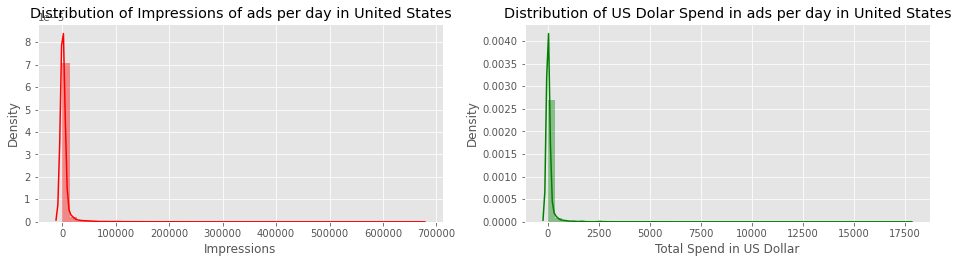

In [159]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.distplot(ads_data['impressions_per_ads'],color = 'red').set(title = 'Distribution of Impressions of ads per day in United States',xlabel ='Impressions')
plt.subplot(2,2,2)
sns.distplot(ads_data['usd_per_ads_day'],color='green').set(title = 'Distribution of US Dolar Spend in ads per day in United States',xlabel ='Total Spend in US Dollar')

Terlihat dan dibuktikan dalam distribution plot bahwa persebaran impressions dan total spend di United States ini memiliki tipe distribusi positive skew. Sehingga banyak distribusi value berada di sisi kiri mean.

### Distributions of US Spend with Total Impression (Scatter Plot)

Text(0.5, 1.0, 'The Distributions of Total Spending with Total Impressions ')

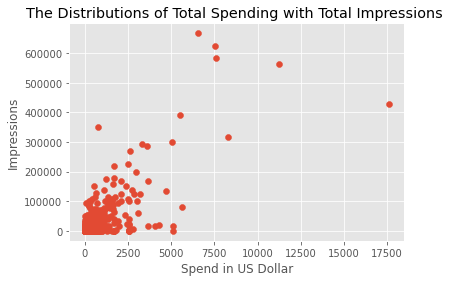

In [160]:
plt.scatter(y=ads_data['impressions_per_ads'],x=ads_data['usd_per_ads_day'])
plt.xlabel('Spend in US Dollar')
plt.ylabel('Impressions')
plt.title("The Distributions of Total Spending with Total Impressions ")

Dapat disimpulkan bahwa perilaku warga United States pada umumnya  baik itu pada setiap organisasi atau individu melakukan budgeting untuk political ads di google untuk 1 iklannya dalam 1 hari di bawah 7.500 US Dollar dengan mendapatkan impression di bawah 300.000 impressions. Walupun terdapat juga tidak banyak berada di angka di atas spend dan impression yang telah disebutkan.

## MAP

### Plot based on total_ads

Mencari tahu nilai min dan max total ads

In [161]:
based_geo_long_lat.total_ads.min()

3947

In [162]:
based_geo_long_lat.total_ads.max()

5332

Melakukan sorting values terhadap total_ads nya.

In [163]:
based_geo_long_lat.sort_values('total_ads',ascending=True,inplace=True)
based_geo_long_lat.reset_index(inplace=True)
based_geo_long_lat.drop(columns='index',inplace=True)

In [164]:
based_geo_long_lat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         51 non-null     object 
 1   state           51 non-null     object 
 2   total_district  51 non-null     int64  
 3   total_ads       51 non-null     int64  
 4   total_spend     51 non-null     int64  
 5   latitude        51 non-null     float64
 6   longitude       51 non-null     float64
 7   name            51 non-null     object 
dtypes: float64(2), int64(3), object(3)
memory usage: 3.3+ KB


Total ads setiap state berada di range antara 3947 ads hingga 5332 ads.

Sehingga dilakukan partisi per stages sebagai berikut:

<4000 , 4000 - 4250, 4250-4500, 4500-4750,-4750-5000, >5000

membuat variable stages:

In [165]:
stages= ["< 4000","4001-4500","4501-5000","5000+"]

Melalui tuples ini akan di cari value yang memenuhi dengan kondisi yang sudah di tentukan lalu disimpen indexnya jika memenuhi.

In [166]:
tuple1 = (0, based_geo_long_lat[based_geo_long_lat.total_ads <= 4000].index[-1]+1)
tuple2 = (tuple1[1], based_geo_long_lat[(based_geo_long_lat.total_ads > 4000) & (based_geo_long_lat.total_ads <=4500)].index[-1]+1)
tuple3 = (tuple2[1], based_geo_long_lat[(based_geo_long_lat.total_ads > 4501) & (based_geo_long_lat.total_ads <=5000)].index[-1]+1)
tuple4 = (tuple3[1], based_geo_long_lat[based_geo_long_lat.total_ads > 5001].index[-1]+1)
limits = [tuple1, tuple2, tuple3, tuple4]
limits


[(0, 1), (1, 13), (13, 40), (40, 51)]

Membuat variable colors untuk membedakan warna setiap stages nya.

In [167]:
colors = ["#F4C2C2","#FF6961","#FF1C00","#D73B3E","#A40000", "#321414"]

Melakukan plotting maps dengan kombinasi scatter plot dengan menggunakan library plotly disini dengan input juga latitude dan longitudenya dan juga beberapa kategori stages yang telah dibuat sebelumnya.

In [168]:
fig = go.Figure()
stage_counter = 0
for i in range(len(limits)):
    lim = limits[i]
    df_sub = based_geo_long_lat[lim[0]:lim[1]]
    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = df_sub['longitude'],
        lat = df_sub['latitude'],
        text = df_sub['name'],
        marker = dict(
            size = df_sub['total_ads']*0.1,
            color = colors[i],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode = 'area'
        ),
        name = '{}'.format(stages[stage_counter])))
    stage_counter = stage_counter+1

In [169]:
fig.update_layout(
        title_text = 'Total Political Ads Distribution In The United States By Geography',
        title_x=0.5,
        showlegend = True,
        legend_title = 'Range Of Total Ads',
        geo = dict(
            scope = 'usa',
            landcolor = 'rgb(217, 217, 217)',
            projection=go.layout.geo.Projection(type = 'albers usa'),
        )
    )

Dapat dilihat bahwa persebaran ads di setiap state ini memiliki range yang tidak jauh, berada di range 3900 hingga 5000. Dapat dilihat juga berdasarkan warna bahwa total ads yang tersebar setiap statesnya mayoritas diatas 4500 ads per statenya.

### Plot based on total_spend

Melakukan sorting values terhadap total_ads nya.

In [170]:
based_geo_long_lat.sort_values('total_spend',ascending=True,inplace=True)
based_geo_long_lat.reset_index(inplace=True)
based_geo_long_lat.drop(columns='index',inplace=True)

Sehingga dilakukan partisi per stages sebagai berikut:
`"< 5.000.000","5.000.001-10.000.000","10.000.001-20.000.000","20.000.001-30.000.000","30.000.001-40.000.000","40.000.001-50.000.000", "50.000.001-60.000.000","60.000.001-70.000.000","70.000.001-80.000.000", "80.000.000+"`

In [171]:
stage_spend= ["< 5.000.000","5.000.001-10.000.000","10.000.001-20.000.000","20.000.001-30.000.000","30.000.001-40.000.000","40.000.001-50.000.000", "50.000.001-60.000.000","60.000.001-70.000.000","70.000.001-80.000.000", "80.000.000+"]

Melalui tuples ini akan di cari value yang memenuhi dengan kondisi yang sudah di tentukan lalu disimpen indexnya jika memenuhi.

In [172]:
# Create tuples of row indexes for the above ranges
tuple1_spend = (0, based_geo_long_lat[based_geo_long_lat.total_spend <= 5000000].index[-1]+1)
tuple2_spend = (tuple1_spend[1], based_geo_long_lat[(based_geo_long_lat.total_spend > 5000000) & (based_geo_long_lat.total_spend <=10000000)].index[-1]+1)
tuple3_spend = (tuple2_spend[1], based_geo_long_lat[(based_geo_long_lat.total_spend > 10000000) & (based_geo_long_lat.total_spend <=20000000)].index[-1]+1)
tuple4_spend = (tuple3_spend[1], based_geo_long_lat[(based_geo_long_lat.total_spend > 20000000) & (based_geo_long_lat.total_spend <=30000000)].index[-1]+1)
tuple5_spend = (tuple4_spend[1], based_geo_long_lat[(based_geo_long_lat.total_spend > 30000000) & (based_geo_long_lat.total_spend <=40000000)].index[-1]+1)
tuple6_spend = (tuple5_spend[1], based_geo_long_lat[(based_geo_long_lat.total_spend > 40000000) & (based_geo_long_lat.total_spend <=50000000)].index[-1]+1)
tuple7_spend = (tuple6_spend[1], based_geo_long_lat[(based_geo_long_lat.total_spend > 50000000) & (based_geo_long_lat.total_spend <=60000000)].index[-1]+1)
tuple8_spend = (tuple7_spend[1], based_geo_long_lat[(based_geo_long_lat.total_spend > 60000000) & (based_geo_long_lat.total_spend <=70000000)].index[-1]+1)
tuple9_spend = (tuple8_spend[1], based_geo_long_lat[(based_geo_long_lat.total_spend > 70000000) & (based_geo_long_lat.total_spend <=80000000)].index[-1]+1)
tuple10_spend = (tuple9_spend[1], based_geo_long_lat[based_geo_long_lat.total_spend > 80000000].index[-1]+1)

limits_spend = [tuple1_spend, tuple2_spend, tuple3_spend, tuple4_spend, tuple5_spend, tuple6_spend, tuple7_spend, tuple8_spend, tuple9_spend,tuple10_spend]
limits_spend

[(0, 19),
 (19, 27),
 (27, 37),
 (37, 42),
 (42, 44),
 (44, 47),
 (47, 48),
 (48, 49),
 (49, 50),
 (50, 51)]

Membuat variable colors untuk membedakan warna setiap stages nya.

In [173]:
colors_spend = ["#B2EC5D","#7CFC00","#ACE1AF","#77DD77","#85BB65", "#03C03C","#008000","#78866B","#556B2F","#414833"]

Melakukan plotting maps dengan kombinasi scatter plot dengan menggunakan library plotly disini dengan input juga latitude dan longitudenya dan juga beberapa kategori stages yang telah dibuat sebelumnya.

In [174]:
fig_spend = go.Figure()
stage_spend_counter = 0
for i in range(len(limits_spend)):
    lim_spend = limits_spend[i]
    df_sub_spend = based_geo_long_lat[lim_spend[0]:lim_spend[1]]
    fig_spend.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = df_sub_spend['longitude'],
        lat = df_sub_spend['latitude'],
        text = df_sub_spend['name'],
        marker = dict(
            size = df_sub_spend['total_spend']*0.00002,
            color = colors_spend[i],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode = 'area'
        ),
        name = '{}'.format(stage_spend[stage_spend_counter])))
    stage_spend_counter = stage_spend_counter+1

In [175]:
fig_spend.update_layout(
        title_text = 'Total Spending on Political Ads Distribution In The United States By Geography',
        title_x=0.5,
        showlegend = True,
        legend_title = 'Range Of Total Spending in US Dollar',
        geo = dict(
            scope = 'usa',
            landcolor = 'rgb(217, 217, 217)',
            projection=go.layout.geo.Projection(type = 'albers usa'),
        )
    )

Dapat dilihat bahwa persebaran total spending di setiap state ini memiliki range yang bervariasi. Dapat dilihat juga berdasarkan warna dan ukuran buble bahwa terdapat daerah yang total spendingnya sedikit dan juga terdapat daerah yang total spendingnya besar.

## Gender plot

Melakukan plotting pie chart pada gender target.

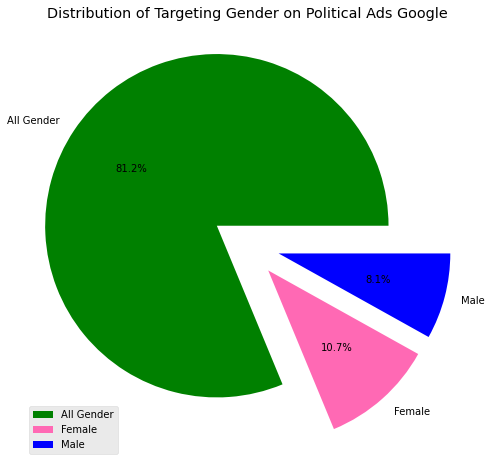

In [176]:
myexplode = [0.2, 0, 0, 0]
pie_chart = plt.figure(figsize=(8,8))
plt.pie(based_gender_sum.persentase, labels = based_gender_sum.gender, explode= [0.2, 0.2, 0.2], colors = ['green','hotpink','blue'],autopct='%1.1f%%')
plt.title('Distribution of Targeting Gender on Political Ads Google')
plt.legend()
plt.axis('equal')
plt.show()

Berdasarkan pada pie chart di atas, kita dapat mendapatkan informasi bahwa 80.2 persen dari total ads bertarget pada semua gender, 10.7 persen bertarget pada gender perempuan, dan 8.1 persen bertarget pada gender laki-laki. 

## Ads Type

Pada section ini akan melakukan analisa inferensia, yang dimana perlu diberi perlakuan terlebih dahul datanya untuk menghilangkan outliernya.

### Text


Menunjukan summary statistic yang diperlukan sebagai informasi persebaran dan juga untuk digunakan filtering outliers.

In [177]:
mean_impression_text = text['impressions'].mean()
median_impression_text = text['impressions'].median()
mode_impression_text = text['impressions'].mode()
skew_impression_text = text['impressions'].skew()
kurt_impression_text = text['impressions'].kurt()
var_impression_text = text['impressions'].var()
std_impression_text = text['impressions'].std()
quartiles_impression_text = np.percentile(text['impressions'],[25,50,75])
min_impression_text,max_impression_text = text['impressions'].min(),text['impressions'].max()

print(f"Mean dari impressions at text ads {mean_impression_text}")
print(f"Median dari impressions at text ads {median_impression_text}")
print(f"Mode dari impressions at text ads {mode_impression_text[0]}")
print(f"Skewness dari impressions at text ads {skew_impression_text}")
print(f"Kurtosis dari impressions at text ads {kurt_impression_text}")
print(f"Variance dari impression at text ads {var_impression_text}")
print(f"Standard Deviation dari impression at text ads {std_impression_text}")
print(f"Q1 dari impression at text ads {quartiles_impression_text[0]}")
print(f"Q3 dari impression at text ads {quartiles_impression_text[2]}")
print(f"Min dari impression at text ads {min_impression_text}")
print(f"Max dari impressionat text ads {max_impression_text}")

Mean dari impressions at text ads 13687.290232254847
Median dari impressions at text ads 1000.0
Mode dari impressions at text ads 1000
Skewness dari impressions at text ads 35.24897459377977
Kurtosis dari impressions at text ads 1736.669305076264
Variance dari impression at text ads 17666135062.864388
Standard Deviation dari impression at text ads 132914.01379412325
Q1 dari impression at text ads 1000.0
Q3 dari impression at text ads 3000.0
Min dari impression at text ads 1000
Max dari impressionat text ads 10000000


Berdasarkan data ini, tipe distribusinya adalah positive right skew karena skewness > 0 dan juga posisi mean di sebelah kanan median.

c:\Users\maula\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\Users\maula\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



[Text(0.5, 1.0, 'Boxplot of Impressions of Text Ads in United States'),
 Text(0.5, 0, 'Impression ')]

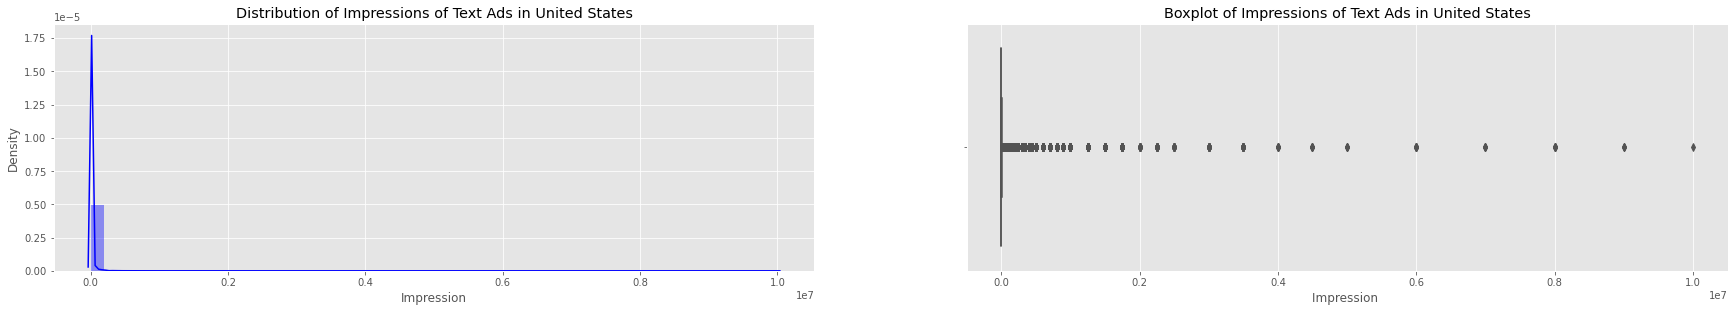

In [178]:
plt.figure(figsize=(30,10))
plt.subplot(2,2,1)
sns.distplot(text['impressions'],color = 'blue').set(title = 'Distribution of Impressions of Text Ads in United States',xlabel ='Impression')
plt.subplot(2,2,2)
sns.boxplot(text['impressions']).set(title = 'Boxplot of Impressions of Text Ads in United States',xlabel ='Impression ')


Terlihat pada box plot terdapat outliers (plotting sebelah kanan).

Mendeteksi dan menghilangkan outliers dengan metode turkey's rule karena data tidak distribusi normal.

Interval berada pada value minimum -2000.0 hingga value maximum 6000.0


c:\Users\maula\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\Users\maula\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

c:\Users\maula\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\Users\maula\anaconda3\lib\site-packages\seaborn

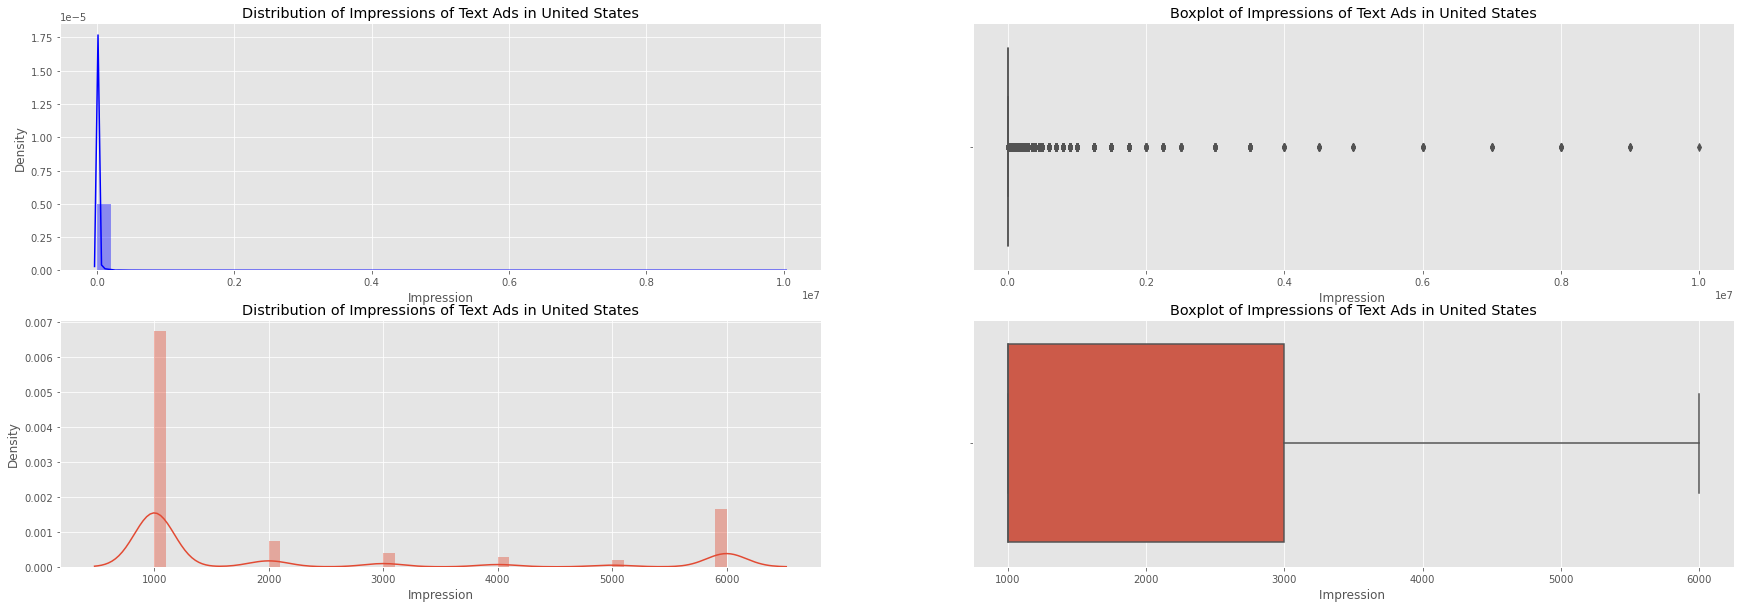

In [179]:
IQR_text = quartiles_impression_text[2] - quartiles_impression_text[0]
batas_bawah_text = quartiles_impression_text[0] - 1.5*IQR_text
batas_atas_text = quartiles_impression_text [2] + 1.5*IQR_text

print(f'Interval berada pada value minimum {batas_bawah_text} hingga value maximum {batas_atas_text}')
new_text = text.copy()
new_text = np.where(
    new_text['impressions'] > batas_atas_text,
    batas_atas_text,
    np.where(
        new_text ['impressions'] < batas_bawah_text,
        batas_bawah_text,
        new_text ['impressions']
    )
)
plt.figure(figsize=(30,10))
plt.subplot(2,2,1)
sns.distplot(text['impressions'],color = 'blue').set(title = 'Distribution of Impressions of Text Ads in United States',xlabel ='Impression')
plt.subplot(2,2,2)
sns.boxplot(text['impressions']).set(title = 'Boxplot of Impressions of Text Ads in United States',xlabel ='Impression ')
plt.subplot(2,2,3)
sns.distplot(new_text).set(title = 'Distribution of Impressions of Text Ads in United States',xlabel ='Impression')
plt.subplot(2,2,4)
sns.boxplot(new_text).set(title = 'Boxplot of Impressions of Text Ads in United States',xlabel ='Impression ')
plt.subplot(2,2,3)
plt.show()

Terlihat perbandingannya bagian atas (sebelum filter) bagian bawah (sesudah filter), pada boxplot terlihat bahwa sudah tidak ada outliersnya.

### Image

Menunjukan summary statistic yang diperlukan sebagai informasi persebaran dan juga untuk digunakan filtering outliers.

In [180]:
mean_impression_image = image['impressions'].mean()
median_impression_image = image['impressions'].median()
mode_impression_image = image['impressions'].mode()
skew_impression_image = image['impressions'].skew()
kurt_impression_image = image['impressions'].kurt()
var_impression_image = image['impressions'].var()
std_impression_image = image['impressions'].std()
quartiles_impression_image = np.percentile(image['impressions'],[25,50,75])
min_impression_image,max_impression_image = image['impressions'].min(),image['impressions'].max()

print(f"Mean dari impressions at image ads {mean_impression_image}")
print(f"Median dari impressions at image ads {median_impression_image}")
print(f"Mode dari impressions at image ads {mode_impression_image[0]}")
print(f"Skewness dari impressions at image ads {skew_impression_image}")
print(f"Kurtosis dari impressions at image ads {kurt_impression_image}")
print(f"Variance dari impression at image ads {var_impression_image}")
print(f"Standard Deviation dari impression at image ads {std_impression_image}")
print(f"Q1 dari impression at image ads {quartiles_impression_image[0]}")
print(f"Q3 dari impression at image ads {quartiles_impression_image[2]}")
print(f"Min dari impression at image ads {min_impression_image}")
print(f"Max dari impressionat image ads {max_impression_image}")

Mean dari impressions at image ads 108119.3141956503
Median dari impressions at image ads 3000.0
Mode dari impressions at image ads 1000
Skewness dari impressions at image ads 10.656405300760984
Kurtosis dari impressions at image ads 138.5589972655688
Variance dari impression at image ads 309382450865.4158
Standard Deviation dari impression at image ads 556221.5843217663
Q1 dari impression at image ads 1000.0
Q3 dari impression at image ads 25000.0
Min dari impression at image ads 1000
Max dari impressionat image ads 10000000


Berdasarkan data ini, tipe distribusinya adalah positive right skew karena skewness > 0 dan juga posisi mean di sebelah kanan median.

c:\Users\maula\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\Users\maula\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



[Text(0.5, 1.0, 'Boxplot of Impressions of image Ads in United States'),
 Text(0.5, 0, 'Impression ')]

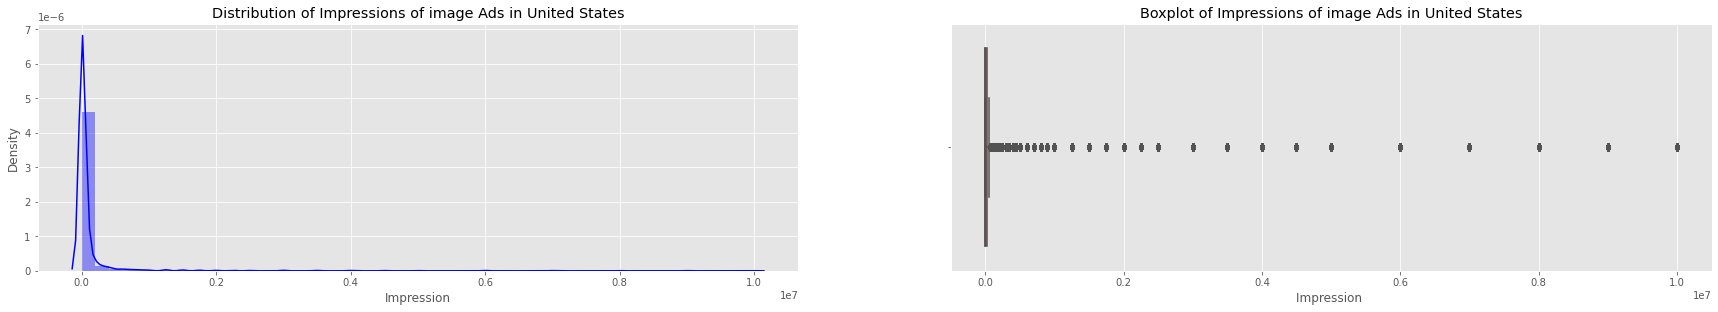

In [181]:
plt.figure(figsize=(30,10))
plt.subplot(2,2,1)
sns.distplot(image['impressions'],color = 'blue').set(title = 'Distribution of Impressions of image Ads in United States',xlabel ='Impression')
plt.subplot(2,2,2)
sns.boxplot(image['impressions']).set(title = 'Boxplot of Impressions of image Ads in United States',xlabel ='Impression ')


Terlihat pada box plot terdapat outliers.

Mendeteksi dan menghilangkan outliers dengan metode turkey's rule karena data tidak distribusi normal.

Interval berada pada value minimum -35000.0 hingga value maximum 61000.0


c:\Users\maula\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\Users\maula\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

c:\Users\maula\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\Users\maula\anaconda3\lib\site-packages\seaborn

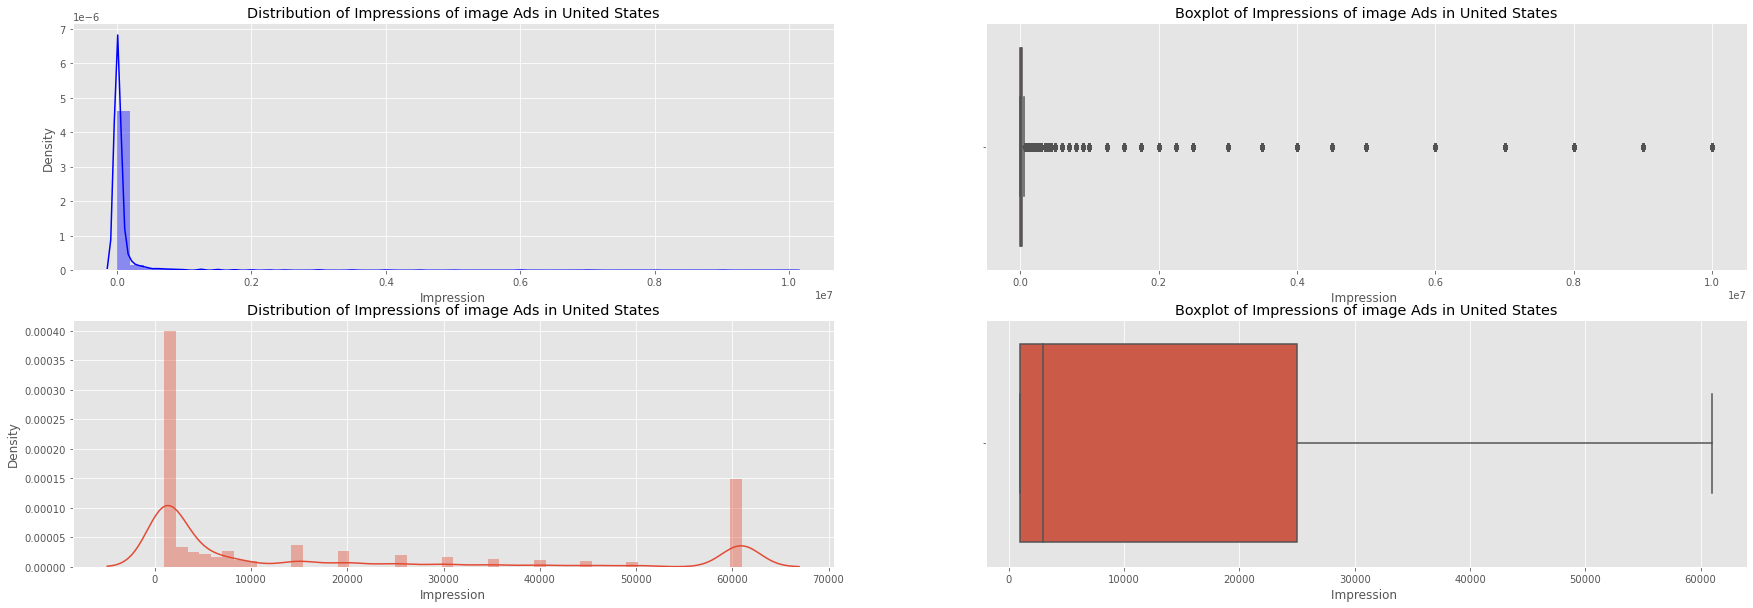

In [182]:
IQR_image = quartiles_impression_image[2] - quartiles_impression_image[0]
batas_bawah_image = quartiles_impression_image[0] - 1.5*IQR_image
batas_atas_image = quartiles_impression_image [2] + 1.5*IQR_image

print(f'Interval berada pada value minimum {batas_bawah_image} hingga value maximum {batas_atas_image}')
new_image = image.copy()
new_image = np.where(
    new_image['impressions'] > batas_atas_image,
    batas_atas_image,
    np.where(
        new_image['impressions'] < batas_bawah_image,
        batas_bawah_image,
        new_image['impressions']
    )
)
plt.figure(figsize=(30,10))
plt.subplot(2,2,1)
sns.distplot(image['impressions'],color = 'blue').set(title = 'Distribution of Impressions of image Ads in United States',xlabel ='Impression')
plt.subplot(2,2,2)
sns.boxplot(image['impressions']).set(title = 'Boxplot of Impressions of image Ads in United States',xlabel ='Impression ')
plt.subplot(2,2,3)
sns.distplot(new_image).set(title = 'Distribution of Impressions of image Ads in United States',xlabel ='Impression')
plt.subplot(2,2,4)
sns.boxplot(new_image).set(title = 'Boxplot of Impressions of image Ads in United States',xlabel ='Impression ')
plt.subplot(2,2,3)
plt.show()

Terlihat perbandingannya bagian atas (sebelum filter) bagian bawah (sesudah filter), pada boxplot terlihat bahwa sudah tidak ada outliersnya.

### Video

Menunjukan summary statistic yang diperlukan sebagai informasi persebaran dan juga untuk digunakan filtering outliers.

In [183]:
mean_impression_video = video['impressions'].mean()
median_impression_video = video['impressions'].median()
mode_impression_video = video['impressions'].mode()
skew_impression_video = video['impressions'].skew()
kurt_impression_video = video['impressions'].kurt()
var_impression_video = video['impressions'].var()
std_impression_video = video['impressions'].std()
quartiles_impression_video = np.percentile(video['impressions'],[25,50,75])
min_impression_video,max_impression_video = video['impressions'].min(),video['impressions'].max()

print(f"Mean dari impressions at video ads {mean_impression_video}")
print(f"Median dari impressions at video ads {median_impression_video}")
print(f"Mode dari impressions at video ads {mode_impression_video[0]}")
print(f"Skewness dari impressions at video ads {skew_impression_video}")
print(f"Kurtosis dari impressions at video ads {kurt_impression_video}")
print(f"Variance dari impression at video ads {var_impression_video}")
print(f"Standard Deviation dari impression at video ads {std_impression_video}")
print(f"Q1 dari impression at video ads {quartiles_impression_video[0]}")
print(f"Q3 dari impression at video ads {quartiles_impression_video[2]}")
print(f"Min dari impression at video ads {min_impression_video}")
print(f"Max dari impressionat video ads {max_impression_video}")

Mean dari impressions at video ads 120618.65412574548
Median dari impressions at video ads 9000.0
Mode dari impressions at video ads 1000
Skewness dari impressions at video ads 10.200031243027905
Kurtosis dari impressions at video ads 143.5425725378272
Variance dari impression at video ads 214376063028.97137
Standard Deviation dari impression at video ads 463007.6273982658
Q1 dari impression at video ads 1000.0
Q3 dari impression at video ads 60000.0
Min dari impression at video ads 1000
Max dari impressionat video ads 10000000


Berdasarkan data ini, tipe distribusinya adalah positive right skew karena skewness > 0 dan juga posisi mean di sebelah kanan median.

c:\Users\maula\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\Users\maula\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



[Text(0.5, 1.0, 'Boxplot of Impressions of video Ads in United States'),
 Text(0.5, 0, 'Impression ')]

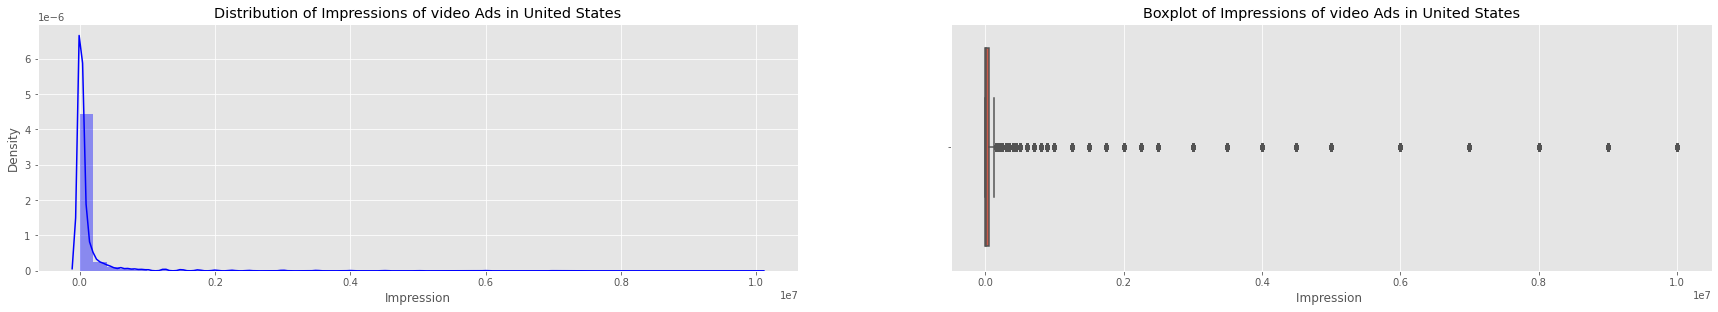

In [184]:
plt.figure(figsize=(30,10))
plt.subplot(2,2,1)
sns.distplot(video['impressions'],color = 'blue').set(title = 'Distribution of Impressions of video Ads in United States',xlabel ='Impression')
plt.subplot(2,2,2)
sns.boxplot(video['impressions']).set(title = 'Boxplot of Impressions of video Ads in United States',xlabel ='Impression ')


Terlihat pada box plot terdapat outliers.

Mendeteksi dan menghilangkan outliers dengan metode turkey's rule karena data tidak distribusi normal.

Interval berada pada value minimum -87500.0 hingga value maximum 148500.0


c:\Users\maula\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\Users\maula\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

c:\Users\maula\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\Users\maula\anaconda3\lib\site-packages\seaborn

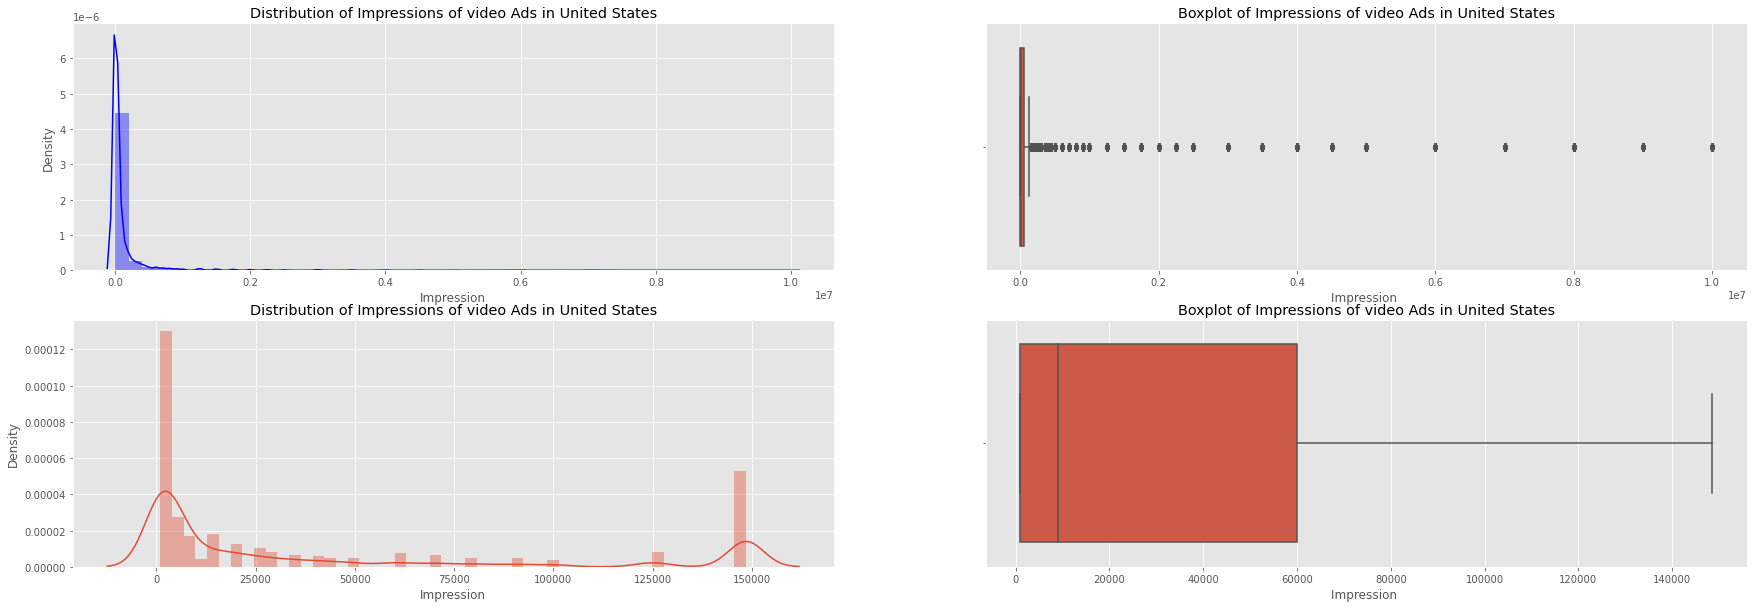

In [185]:
IQR_video = quartiles_impression_video[2] - quartiles_impression_video[0]
batas_bawah_video = quartiles_impression_video[0] - 1.5*IQR_video
batas_atas_video = quartiles_impression_video [2] + 1.5*IQR_video

print(f'Interval berada pada value minimum {batas_bawah_video} hingga value maximum {batas_atas_video}')
new_video = video.copy()
new_video = np.where(
    new_video['impressions'] > batas_atas_video,
    batas_atas_video,
    np.where(
        new_video['impressions'] < batas_bawah_video,
        batas_bawah_video,
        new_video['impressions']
    )
)
plt.figure(figsize=(30,10))
plt.subplot(2,2,1)
sns.distplot(video['impressions'],color = 'blue').set(title = 'Distribution of Impressions of video Ads in United States',xlabel ='Impression')
plt.subplot(2,2,2)
sns.boxplot(video['impressions']).set(title = 'Boxplot of Impressions of video Ads in United States',xlabel ='Impression ')
plt.subplot(2,2,3)
sns.distplot(new_video).set(title = 'Distribution of Impressions of video Ads in United States',xlabel ='Impression')
plt.subplot(2,2,4)
sns.boxplot(new_video).set(title = 'Boxplot of Impressions of video Ads in United States',xlabel ='Impression ')
plt.subplot(2,2,3)
plt.show()

Terlihat perbandingannya bagian atas (sebelum filter) bagian bawah (sesudah filter), pada boxplot terlihat bahwa sudah tidak ada outliersnya.

### Anova Analysis

Di section ini Saya ingin menganalisa ketiga variabel tipe ads (text, image, video),
Apakah antar variabel tersebut memiliki kesamaan dalam mendapatkan impression atau statistically significant perbedaannya.

Dengan Hipotesis sebagai berikut:

```txt
H0 : Antar Tipe Ads tidak memiliki perbedaan terhadap impression yang di dapat, μtext = μimage = μvideo.
H1 : Antar Tipe Ads memiliki perbedaan significant terhadap impression yang di dapat, μtext != μimage != μvideo.
```

Karena disini terdapat tiga variabel maka Saya menggunakan Analysis ANOVA dengan menggunakan fungsi yang sudah ada pada library scipy.stats

In [186]:
f_stat,p_value = stats.f_oneway(pd.DataFrame(new_text),pd.DataFrame(new_image),pd.DataFrame(new_video))
print('P-value:',p_value[0])
print('f-stat:',f_stat[0])

P-value: 0.0
f-stat: 53261.970515553265


Sehingga didapat p-value < 0,05, maka H0 di reject. 

`Dapat disimpulkan bahwa terdapat perbedaan statistically significant antara Ads Type Text, Image, dan Video terhadap impressions yang di dapat.`

### Mean, min, max analysis

Dengan menggunakan data yang sudah bersih dari outliers dicari value average rata-rata, minimum, dan maximumnya:

In [187]:
print(f"Rata-rata impression yang di dapat dengan menggunakan ads text adalah {round(new_text.mean(),2)} impressions")
print(f"Minimum impression yang di dapat dengan menggunakan ads text adalah {round(new_text.min(),2)} impressions")
print(f"Maximum impression yang di dapat dengan menggunakan ads text adalah {round(new_text.max(),2)} impressions")

Rata-rata impression yang di dapat dengan menggunakan ads text adalah 2143.56 impressions
Minimum impression yang di dapat dengan menggunakan ads text adalah 1000.0 impressions
Maximum impression yang di dapat dengan menggunakan ads text adalah 6000.0 impressions


In [188]:
print(f"Rata-rata impression yang di dapat dengan menggunakan ads image adalah {round(new_image.mean(),2)} impressions")
print(f"Minimum impression yang di dapat dengan menggunakan ads image adalah {round(new_image.min(),2)} impressions")
print(f"Maximum impression yang di dapat dengan menggunakan ads image adalah {round(new_image.max(),2)} impressions")

Rata-rata impression yang di dapat dengan menggunakan ads image adalah 16956.66 impressions
Minimum impression yang di dapat dengan menggunakan ads image adalah 1000.0 impressions
Maximum impression yang di dapat dengan menggunakan ads image adalah 61000.0 impressions


In [189]:
print(f"Rata-rata impression yang di dapat dengan menggunakan ads video adalah {round(new_video.mean(),2)} impressions")
print(f"Minimum impression yang di dapat dengan menggunakan ads video adalah {round(new_video.min(),2)} impressions")
print(f"Maximum impression yang di dapat dengan menggunakan ads video adalah {round(new_video.max(),2)} impressions")

Rata-rata impression yang di dapat dengan menggunakan ads video adalah 39772.97 impressions
Minimum impression yang di dapat dengan menggunakan ads video adalah 1000.0 impressions
Maximum impression yang di dapat dengan menggunakan ads video adalah 148500.0 impressions


Dapat dilihat bahwa ads type video memiliki impression yang lebih banyak di banding ads type lainnya.

Membuat data frame baru untuk melakukan barplot.

In [190]:
mean_m=[round(new_text.mean(),2),round(new_image.mean(),2),round(new_video.mean(),2)]

In [191]:
min_m=[round(new_text.min(),2),round(new_image.min(),2),round(new_video.min(),2)]

In [192]:
max_m =[round(new_text.max(),2),round(new_image.max(),2),round(new_video.max(),2)]

In [193]:
data_mean_min_max_type = pd.DataFrame()

In [194]:
data_mean_min_max_type['Text'] = [round(new_text.mean(),2),round(new_text.min(),2),round(new_text.max(),2)]

In [195]:
data_mean_min_max_type['Image'] = [round(new_image.mean(),2),round(new_image.min(),2),round(new_image.max(),2)]

In [196]:
data_mean_min_max_type['Video'] = [round(new_video.mean(),2),round(new_video.min(),2),round(new_video.max(),2)]

In [197]:
data_mean_min_max_type = data_mean_min_max_type.set_axis(['Average','Minimum','Maximum'])

<AxesSubplot:title={'center':'Ads Type Comparison in Average, Minimum, and Maximum'}>

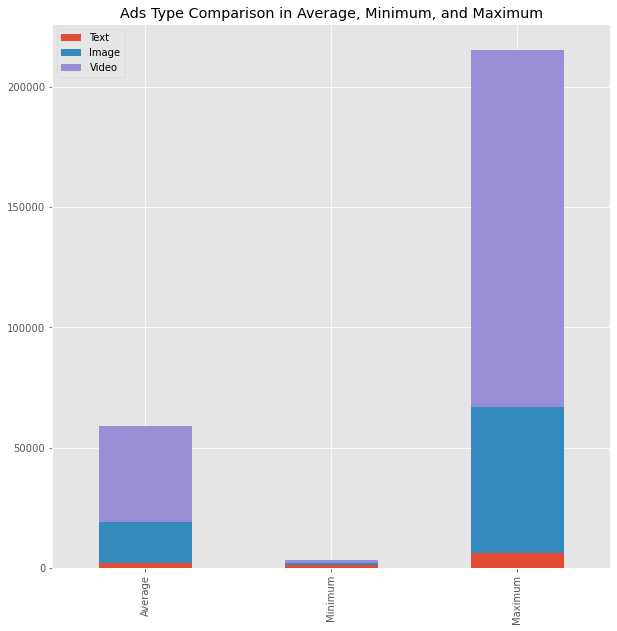

In [198]:
data_mean_min_max_type.plot(kind='bar',stacked = True,figsize = (10,10),title = 'Ads Type Comparison in Average, Minimum, and Maximum')

Sehingga dapat dilihat pada barplot bahwa proporsi impression yang di hasilkan dari tiap ads type. 
```txt
Di dapatkan bahwa ads type video memiiki impression rata-rata dan maximum tertinggi, lalu diikuti oleh Image, kemudian yang terakhir adalah Text. Untuk Minimum memiliki value yang sama yaitu 1000 impression pada ketiga tipe ads.
```

Membuat variabel color untuk memberikan pewarnaan yang berbeda pada tiap tie data, dimana Text berwarna biru, Image berwarna hitam, dan Video berwarna merah.

In [199]:
color1 =[]

In [200]:
for i in range(0,len(based_ads_type)):
    if based_ads_type.iloc[i,1] == 'TEXT':
        color1.append('blue')
    elif based_ads_type.iloc[i,1] == 'IMAGE':
        color1.append('black')
    elif based_ads_type.iloc[i,1] == 'VIDEO':
        color1.append('red')
        

In [201]:
based_ads_type['color'] = color1

In [202]:
based_ads_type.head()

,regions,ad_type,impressions,spend_usd,color
0,US,IMAGE,8000,100,black
1,US,IMAGE,30000,400,black
2,US,IMAGE,1000,100,black
3,US,IMAGE,80000,500,black
4,US,IMAGE,1000,100,black


In [203]:
#based_ads_type.to_csv('colorplot.csv')

Melakukan scatter plotting untuk melihat hubungan antara impression dan spending us dollar.

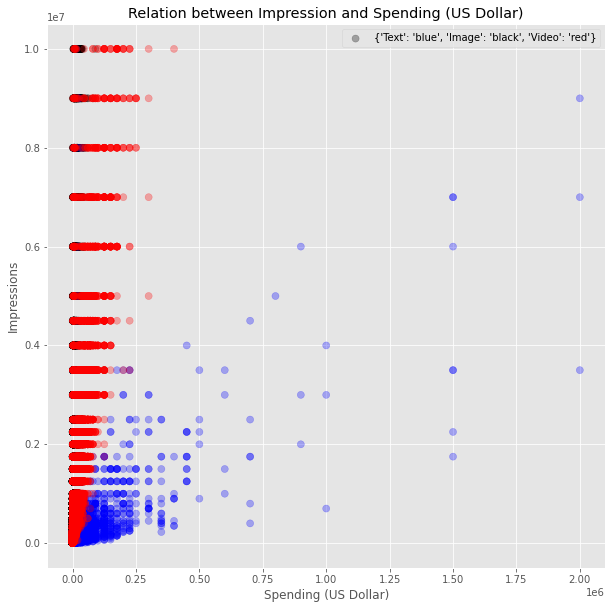

In [204]:
plt.figure(figsize=(10,10))
plt.style.use('ggplot')
plt.title('Relation between Impression and Spending (US Dollar)')
plt.xlabel('Spending (US Dollar)')
plt.ylabel('Impressions')
plt.scatter(x=based_ads_type['spend_usd'],y=based_ads_type['impressions'],s=50,c=based_ads_type['color'],alpha=0.3,marker='o',label = {'Text' : 'blue', 'Image': 'black', 'Video': 'red'})
plt.legend() 
plt.show()

Berdasarkan scatter plot di atas bahwa, pada data political_ads ini banyak yang spending besar pada ads tipe Text namun dengan impressions yang di dapat tidak cukup besar, berbeda dengan ads_type Image dan Video yang dimana spending yang dikeluarkan lebih kecil dibanding text, tetapi mendaptkan impressions yang lebih besar.

# Jawaban pada setiap masalah:

* Bagaimana perilaku warga United States dalam mengeluarkan US dollar untuk sebuah iklan terhadap impression yang di dapat? (Visual)

Text(0.5, 1.0, 'The Distributions of Total Spending with Total Impressions ')

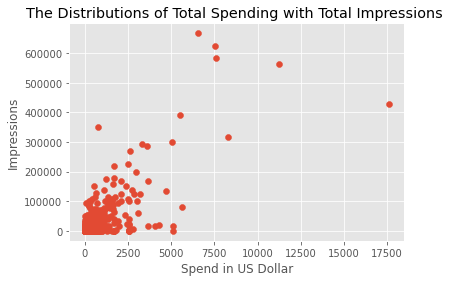

In [205]:
plt.scatter(y=ads_data['impressions_per_ads'],x=ads_data['usd_per_ads_day'])
plt.xlabel('Spend in US Dollar')
plt.ylabel('Impressions')
plt.title("The Distributions of Total Spending with Total Impressions ")

`Dapat disimpulkan bahwa perilaku warga United States pada umumnya  baik itu pada setiap organisasi atau individu melakukan budgeting untuk political ads di google untuk 1 iklannya dalam 1 hari di bawah 7.500 US Dollar dengan mendapatkan impression di bawah 300.000 impressions. Walupun terdapat juga tidak banyak berada di angka di atas spend dan impression yang telah disebutkan.`

* Bagiamana persebaran data pada impression yang di dapat dari sebuah ads di United States? (Deskriptif)

`Berdasarkan analisa central tendecy dari jumlah impression per iklan dalam sehari ini memiliki distribusi positive skew yang dimana mean > median. Hal ini berarti total impression lebih banyak frekuensinya di sebelah kiri dari nilai rata-ratanya. Selain itu juga didukung dengan nilai skewness yang positive >0. Selain itu pada distribusi ini sangat runcing atau terpusat mendekati pada 1 value yang dapat dilihat pada distribusi. Setelah dilihat, hal ini didukung karena nilai kurtosis nya yang sangat tinggi.`

`Rata-rata di US untuk dalam political google ads didapat dalam satu ads per harinya sebanyak 3866 impressions. Dari persebaran data impression per ads per harinya paling banyak frekuensi impressions didapat sebanyak 250 impressions.`

* Bagiamana persebaran data pada US dollar yang dikeluarkan untuk sebuah ads di United States? (Deskriptif)

`Berdasarkan analisa central tendecy dari jumlah impression per iklan dalam sehari ini memiliki distribusi positive skew yang dimana mean > median. Hal ini berarti total impression lebih banyak frekuensinya di sebelah kiri dari nilai rata-ratanya. Selain itu juga didukung dengan nilai skewness yang positive >0. Selain itu pada distribusi ini sangat runcing atau terpusat mendekati pada 1 value yang dapat dilihat pada distribusi. Setelah dilihat, hal ini didukung karena nilai kurtosis nya yang sangat tinggi.`

`Rata-rata di US melakukan spending per ads per harinya untuk political google ads sebanyak 89 US Dollar. Dari persebaran data impression per ads per harinya paling banyak frekuensi spending didapat sebanyak 100 US Dollar.`

* Bagaimana persebaran total ads yang ditujukan pada setiap states di United States?(Visual)

In [206]:
fig

`Dapat dilihat bahwa persebaran ads di setiap state ini memiliki range yang tidak jauh, berada di range 3900 hingga 5000. Dapat dilihat juga berdasarkan warna bahwa total ads yang tersebar setiap statesnya mayoritas diatas 4500 ads per statenya.`

* Bagaimana persebaran total dana yang dikeluarkan pada suatu iklan yang ditujukan pada setiap states di United States? (Visual)

In [207]:
fig_spend

`Dapat dilihat bahwa persebaran total spending di setiap state ini memiliki range yang bervariasi. Dapat dilihat juga berdasarkan warna dan ukuran buble bahwa terdapat daerah yang total spendingnya sedikit dan juga terdapat daerah yang total spendingnya besar.`

* Gender apa saja yang menjadi target dalam political ads? Bagaimana proporsinya? (Visual)

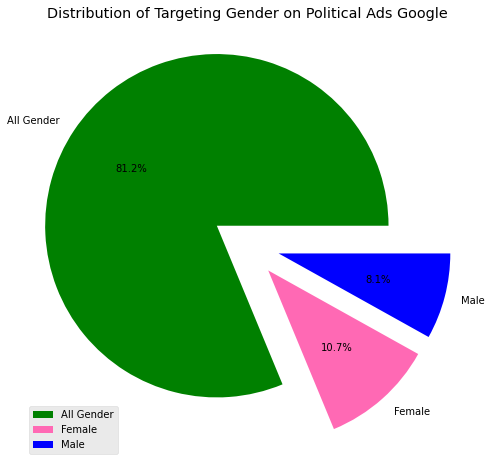

In [208]:
myexplode = [0.2, 0, 0, 0]
pie_chart = plt.figure(figsize=(8,8))
plt.pie(based_gender_sum.persentase, labels = based_gender_sum.gender, explode= [0.2, 0.2, 0.2], colors = ['green','hotpink','blue'],autopct='%1.1f%%')
plt.title('Distribution of Targeting Gender on Political Ads Google')
plt.legend()
plt.axis('equal')
plt.show()

`Berdasarkan pada pie chart di atas, kita dapat mendapatkan informasi bahwa 80.2 persen dari total ads bertarget pada semua gender, 10.7 persen bertarget pada gender perempuan, dan 8.1 persen bertarget pada gender laki-laki. `

* Apakah impressions yang didapatkan pada setiap tipe ads sama? (Inferensial)


Di section ini Saya ingin menganalisa ketiga variabel tipe ads (text, image, video),
Apakah antar variabel tersebut memiliki kesamaan dalam mendapatkan impression atau statistically significant perbedaannya.

Dengan Hipotesis sebagai berikut:
```txt
H0 : Antar Tipe Ads tidak memiliki perbedaan terhadap impression yang di dapat, μtext = μimage = μvideo.
H1 : Antar Tipe Ads memiliki perbedaan significant terhadap impression yang di dapat, μtext != μimage != μvideo.
```

Dengan confidence level 95%, Sehingga didapat p-value < 0,05, maka H0 di reject. 

`Dapat disimpulkan bahwa terdapat perbedaan statistically significant antara Ads Type Text, Image, dan Video terhadap impressions yang di dapat.`

* Tipe ads apa yang paling di rekomendasikan? (Visual)

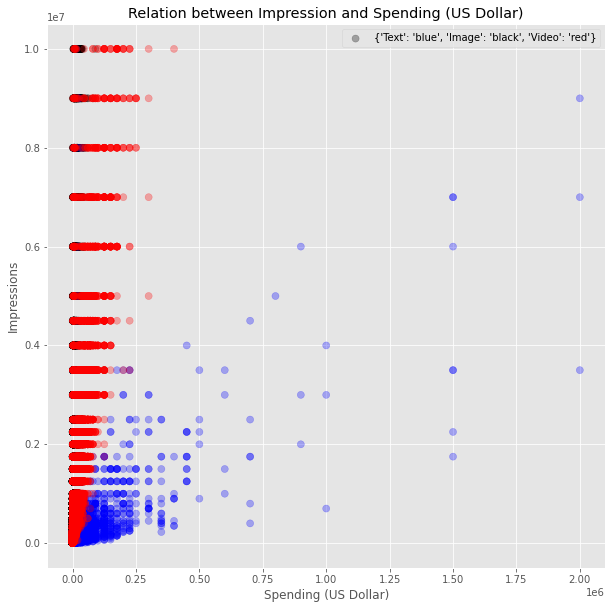

In [209]:
plt.figure(figsize=(10,10))
plt.style.use('ggplot')
plt.title('Relation between Impression and Spending (US Dollar)')
plt.xlabel('Spending (US Dollar)')
plt.ylabel('Impressions')
plt.scatter(x=based_ads_type['spend_usd'],y=based_ads_type['impressions'],s=50,c=based_ads_type['color'],alpha=0.3,marker='o',label = {'Text' : 'blue', 'Image': 'black', 'Video': 'red'})
plt.legend() 
plt.show()

Berdasarkan scatter plot di atas bahwa, pada data political_ads ini banyak yang spending besar pada ads tipe Text namun dengan impressions yang di dapat tidak cukup besar, berbeda dengan ads_type Image dan Video yang dimana spending yang dikeluarkan lebih kecil dibanding text, tetapi mendaptkan impressions yang lebih besar.

`Sehingga direkomendasikan untuk memilih tipe ads yang lebih memberikan impressions yang banyak yaitu video ataupun image dengan total spending yang lebih sedikit dibandingkan tipe text`

# Kesimpulan

`Sehingga kesimpulannya adalah dalam menyusun sebuah budgeting untuk sebuah ads dapat melihat pada penjabaran sebelumnya terkait perilaku warga United States dalam mengeluarkan US dollar untuk sebuah iklan terhadap impression yang di dapat. Dari plotting tersebut, Tim Sukses dapat melakukan budgeting sebuah ads sesuai dengan budget yang ingin dikeluarkan, berapa banyaknya iklan, dan juga jumlah hari iklan tersebut akan ditayangkan. Dari plotting tersebut dapat memperkirakan dengan perilaku yang telah dipelajari sehingga mendapatkan estimasi dari Impressions yang akan di dapat.`

`Selain itu juga pentingnya strategi dimana tujuan iklan itu ditujukan dengan melihat acuan sebelumnya pada plotting secara geografis persebaran total iklan dan total uang yang dikeluarkan pada setiap states.`

`Selain itu juga jika tidak ada gender target lebih diutamakan agar bisa mendapat impression yang lebih banyak melihat pada pie chart bahwa lebih banyak iklan yang bertarget pada semua gender.`

`Yang terakhir adalah pemilihan tipe iklan yang akan dipilih. Ini merupakan hal yang penting, berdasar pada analisis Anova yang dilakukan didapatkan bahwa ketiga tipe ads itu memiliki perbedaan yang significant (statistically significant). Selain itu juga direkomendasikan untuk menggunakan tipe ads berupa image atau video karena berdasarkan pola perilaku tipe ads terhadap spending dan impression yang didapat bahwa tipe image dan video dengan spending ayng lebih sedikit dari tipe text bisa mendapatkan imprssion yang lebih banyak.`